# Описание проекта

## Цель проекта

Разработать нейросеть, способную определять температуру на поверхности звёз, исходя из их характеристик. В наличие имеются данные по 240 уже изученным звёздам

## Описание данных

Датасет содержит следующие данные по объектам:
* Относительная светимость `L/Lo` — светимость звезды относительно Солнца.
* Относительный радиус `R/Ro` — радиус звезды относительно радиуса Солнца.
* Абсолютная звёздная величина `Mv` — физическая величина, характеризующая блеск звезды.
* Звёздный цвет (`white`, `red`, `blue`, `yellow`, `yellow-orange` и др.) — цвет звезды, который определяют на основе спектрального анализа.
* Тип звезды:

| Тип звезды | Номер, соответствующий типу |
| ---------- | --------------------------- |
| Коричневый карлик | 0 |
| Красный карлик | 1 |
| Белый карлик | 2 |
| Звёзды главной последовательности | 3 |
| Сверхгигант | 4 |
| Гипергигант | 5 |

* Абсолютная температура `T(K)` — температура на поверхности звезды в Кельвинах.

# Загрузка данных

## Импорт библиотек

In [33]:
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from os import path
from ydata_profiling import ProfileReport

from fuzzywuzzy import fuzz

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [23]:
import torch
import torch.nn as nn

In [30]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Устройство для PyTorch:', device)

Устройство для PyTorch: cuda


## Глобальные переменные

In [15]:
PATH_LOCAL_DATA = './datasets/6_class.csv'
PATH_CLOUD_DATA = '/datasets/6_class_csv'
RND = 1337 # random state

## Загрузка датасета

In [4]:
if path.exists(PATH_LOCAL_DATA):
    df = pd.read_csv(PATH_LOCAL_DATA, index_col=0)
    # PATH_PROCESSED_DATA = './datasets/autos_processed.csv'  # path to data after cleaning
    print('Loaded from the local storage.\n')
elif path.exists(PATH_CLOUD_DATA):
    df = pd.read_csv(PATH_CLOUD_DATA, index_col=0)
    # PATH_PROCESSED_DATA = '/datasets/autos_processed.csv'  # path to data after cleaning
    print('Loaded from the remote storage.\n')
else:
    raise ValueError('Unable to load data. Check paths to files.')

display(df.head(3), df.info())

Loaded from the local storage.

<class 'pandas.core.frame.DataFrame'>
Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 13.1+ KB


,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.0024,0.1700,16.12,0,Red
1,3042,0.0005,0.1542,16.60,0,Red
2,2600,0.0003,0.1020,18.70,0,Red


None

# Предобработка данных

## Разведывательный анализ

Проведём разведывательный анализ данных с помощью `ydata-profiling`

In [5]:
if 'df_profile' in globals():
    pass
else:
    df_profile = ProfileReport(df)
    df_profile.to_widgets()
    df_profile.to_file('stars-ydata-report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Отчёт выдаёт следующий список предупреждений (алёртов):
* `Temperature (K)` is highly overall correlated with `Absolute magnitude(Mv)` and 1 other fields
* `Luminosity(L/Lo)` is highly overall correlated with `Radius(R/Ro)` and 2 other fields
* `Radius(R/Ro)` is highly overall correlated with `Luminosity(L/Lo)` and 2 other fields
* `Absolute magnitude(Mv)` is highly overall correlated with `Temperature (K)` and 3 other fields
* `Star type` is highly overall correlated with `Temperature (K)` and 4 other fields
* `Star color` is highly overall correlated with `Star type`
* `Star type` has 40 (16.7%) zeros

Последнее предупреждение о том, что `Star type` имеет много нулей, можно игнорировать, потому что в данному случае числа являются категориальными признаками, указывающими на соответствие различным типам звёзд

Рассмотрим подробнее хитмап матрицы корреляций

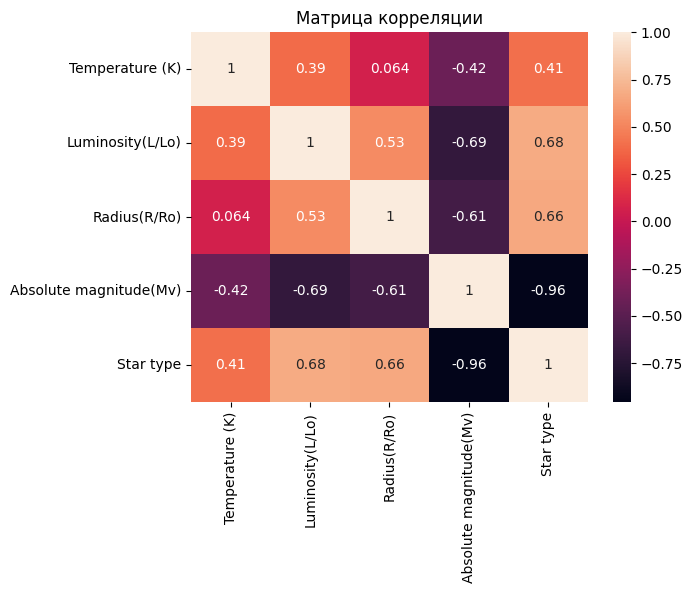

In [6]:
%matplotlib inline
sns.heatmap(df.corr(numeric_only=True), annot=True)
plt.title("Матрица корреляции")
plt.show()

Коэффициент корреляции между `Star type` и `Absolute magnitude` очень высокий, но это связано с тем, что категориальный признак представлен числом. Абсолютные значения коэффициентов корреляции этих столбцов по отношению к остальным также очень близки, за исключением знака.

При подробном изучении столбца `Star type` видно что данные по этому столбцу строго стратифицированы: в датасете присутствует по 40 образцов звёзд каждого типа. Кроме того, эти типы звёзд образуют явно выраженную последовательность от сверхгигантов до коричневых карликов, так что они уже кодированы методом по принципу Ordinal Encoding. В связи с этим мы не будем разбивать классы этой категории по принципу OHE

In [7]:
df["Star type"].value_counts()

Star type
0    40
1    40
2    40
3    40
4    40
5    40
Name: count, dtype: int64

Зависимость между температурой звёзд и абсолютной светимостью похоже на график главной последовательности звёзд

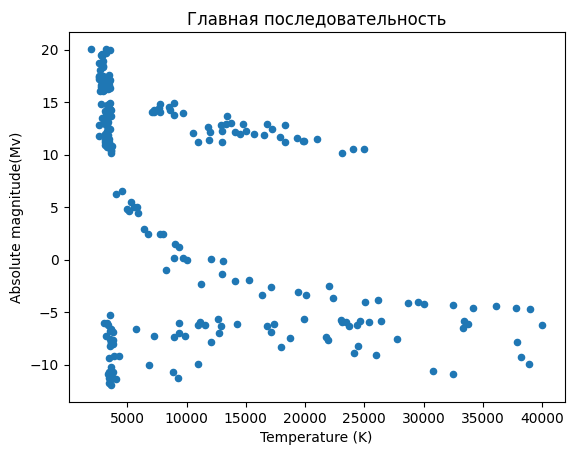

In [8]:
df[["Temperature (K)", "Absolute magnitude(Mv)"]].plot(kind='scatter', x=0, y="Absolute magnitude(Mv)", title="Главная последовательность")
plt.show()

## Подготовка датасета

In [9]:
# переименуем колонки
df.columns = [
    "temperature", "luminosity", "radius", "abs_magnitude", "star_type", "star_color"
]
df.columns

Index(['temperature', 'luminosity', 'radius', 'abs_magnitude', 'star_type',
       'star_color'],
      dtype='object')

Другой интересный столбец `star_color`. Он содержит информацию о цвете, полученную на основе спектрального анализа. Но текст не приведён к одному формату

In [10]:
df["star_color"].unique()

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'Blue ',
       'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ',
       'Blue-White'], dtype=object)

Что касается самих значений, есть два способа обработать классы, имеющие упоминание нескольких цветов:
* обработать смешанные версии цветов как отдельные категории
* ввести отдельный класс для каждого цвета и присваивать их, исходя из описания цвета
* * например, объект с цветом "Pale yellow orange" будет иметь положительный класс по столбцам с жёлтым и оранжевым цветом

Воспользуемся вторым способом. Чтобы классифицировать цвета, будем считать расстояние Левенштейна с помощью библиотеки `fuzzywuzzy`

In [11]:
# список цветов
colors = ["red", "blue", "yellow", "orange", "white"]

# порог для дистанции
levenshtein_distance = 50

Проверим на всех уникальных значениях столбца `star_color`, насколько корректно сработает выбранный метод

In [12]:
# датафрейм с уникальными значениями цветов
df_colors = pd.DataFrame(df["star_color"].unique(), columns=["color"])

# классификация на основе расстояния Левенштейна
for color in colors:
    df_colors["c_"+color] = df_colors["color"].str.casefold().apply(lambda x: 1 if fuzz.ratio(x, color) >= levenshtein_distance else 0)

df_colors

,color,c_red,c_blue,c_yellow,c_orange,c_white
0,Red,1,0,0,0,0
1,Blue White,0,1,0,0,1
2,White,0,0,0,0,1
3,Yellowish White,0,0,1,0,1
4,Blue white,0,1,0,0,1
5,Pale yellow orange,0,0,1,1,0
6,Blue,0,1,0,0,0
7,Blue-white,0,1,0,0,1
8,Whitish,0,0,0,0,1
9,yellow-white,0,0,1,0,1


Всё работает корректно, применим этот метод к основному датафрейму

In [13]:
for color in colors:
    df["c_"+color] = df["star_color"].str.casefold().apply(lambda x: 1 if fuzz.ratio(x, color) >= levenshtein_distance else 0)

df.head(3)

,temperature,luminosity,radius,abs_magnitude,star_type,star_color,c_red,c_blue,c_yellow,c_orange,c_white
0,3068,0.0024,0.1700,16.12,0,Red,1,0,0,0,0
1,3042,0.0005,0.1542,16.60,0,Red,1,0,0,0,0
2,2600,0.0003,0.1020,18.70,0,Red,1,0,0,0,0


In [14]:
# удаляем стобец с цветом
df = df.drop(columns=["star_color"])
df.head(3)

,temperature,luminosity,radius,abs_magnitude,star_type,c_red,c_blue,c_yellow,c_orange,c_white
0,3068,0.0024,0.1700,16.12,0,1,0,0,0,0
1,3042,0.0005,0.1542,16.60,0,1,0,0,0,0
2,2600,0.0003,0.1020,18.70,0,1,0,0,0,0


Чтобы избежать утечки целевого признака в тестовую выборку, будем стандартизировать данные уже после того, как разделим выборки на тренировочную и тестовую

## Подготовка выборок

### Разделение выборок и скалирование

In [21]:
# разделяем датасет и скалируем цифровые признаки
target_feature = "temperature"
stratify_features = ["star_type"]

df_X, df_y = df.drop(columns=[target_feature]).copy(), df[target_feature].copy()
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.25, stratify=df_X[stratify_features], random_state=RND)

for s in X_train, X_test, y_train, y_test:
    print(s.shape)

(180, 9)
(60, 9)
(180,)
(60,)


In [22]:
# скалирование признаков
# признак star_type тоже скалируем

scale_features = ['luminosity', 'radius', 'abs_magnitude', 'star_type']

scaler = StandardScaler()
scaler.fit(X_train[scale_features])

for i in X_train, X_test:
    i[scale_features] = scaler.transform(i[scale_features])
    display(i.head())

,luminosity,radius,abs_magnitude,star_type,c_red,c_blue,c_yellow,c_orange,c_white
221,1.378139,-0.309055,-1.065849,0.87831,0,1,0,0,0
225,0.736672,-0.367767,-1.106434,0.87831,0,1,0,0,0
215,0.433145,-0.445586,-0.814788,0.29277,0,1,0,0,0
97,-0.601586,-0.455169,-0.172980,0.29277,0,0,1,0,1
67,-0.601634,-0.457613,1.149335,-1.46385,1,0,0,0,0


,luminosity,radius,abs_magnitude,star_type,c_red,c_blue,c_yellow,c_orange,c_white
109,1.494120,-0.326669,-0.949757,0.87831,0,1,0,0,0
136,-0.601634,-0.457322,0.675529,-0.87831,1,0,0,0,0
8,-0.601634,-0.457576,1.243719,-1.46385,1,0,0,0,0
237,2.598517,2.327102,-1.416012,1.46385,0,0,0,0,1
123,-0.601634,-0.457609,1.193696,-1.46385,1,0,0,0,0


### Создание тезоров

In [44]:
X_train = torch.FloatTensor(X_train.values)
X_test = torch.FloatTensor(X_test.values)
y_train = torch.FloatTensor(y_train.values)
y_test = torch.FloatTensor(y_test.values)

## Предварительный вывод

# Построение базовой нейронной сети

In [34]:
# постараемся зафиксировать хоть какой-то рандом
random.seed(RND)
np.random.seed(RND)
torch.manual_seed(RND)
torch.use_deterministic_algorithms(True)

# Улучшение базовой нейронной сети

# Выводы